# ELECTRA EN Model

### This notebook contains the implementation of the ELECTRA model pre-trained on the english language set coming from `Datasets/ELECTRA/train_en.csv`

### The following steps are taken to establish the model
- **Data exploration and visualization**
- **Model definition**
- **Optimizer algorithm selection**
- **Loss function selection**
- **Training loop**
- **Model saving**

In [1]:
!pip install -q keras-nlp --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 90.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [2]:
!pip install -q keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.7 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import pandas
import numpy
import keras_nlp
import keras
import keras_tuner
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
import tensorflow
import os
import sklearn.metrics

keras.mixed_precision.set_global_policy("mixed_float16")

label_names = ["entailment", "neutral", "contradiction"]

<ipython-input-3-c0f7e6a58d6c>:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


#### Data Exploration and Visualization

In [4]:
electra_en_dataset = pandas.read_csv("train_en.csv")
electra_en_dataset.head()

,Unnamed: 0,id,premise,hypothesis,lang_abv,language,label,label_name
0,0,a937bd90a8,"3) Dare you rise to the occasion, like Raskol...",Would you rise up and defeaat all evil lords i...,en,English,1,neutral
1,1,0abb9434d5,"He married Dona Filipa Moniz (Perestrelo), the...",He landed on the island but soon left for gree...,en,English,2,contradiction
2,2,bc52edfd5b,The contrast between the landscape of the cent...,There was a beautiful artist who painted the l...,en,English,1,neutral
3,3,62344708db,i don't know i i do i can think of all the uh ...,I know this because I own a bible.,en,English,1,neutral
4,4,03f3c9a92e,'So I assume he hacked into the autopilot and ...,I'm assuming he hacked the autopilot to bring ...,en,English,1,neutral


##### Validation to ensure the data is clean when being passed to the model

In [5]:
electra_en_dataset.isna().sum()

,0
Unnamed: 0,0
id,0
premise,0
hypothesis,0
lang_abv,0
language,0
label,0
label_name,0


In [6]:
(electra_en_dataset.lang_abv != "en").sum()

0

In [7]:
electra_en_dataset.label[~electra_en_dataset.label.isin([0, 1, 2])].any()

False

##### Descriptions and summaries of data

In [8]:
electra_en_dataset.id.count()

3435

- A fairly small dataset relatively speaking to other sources.

In [9]:
electra_en_dataset.hypothesis.describe()

,hypothesis
count,3435
unique,3435
top,Did you do it?
freq,1


In [10]:
for i in range(10):
    print(electra_en_dataset.hypothesis[i])

Would you rise up and defeaat all evil lords in the town?
He landed on the island but soon left for greener pastures, before later dying alone and childless.
There was a beautiful artist who painted the landscape of the central highlands.
I know this because I own a bible.
I'm assuming he hacked the autopilot to bring the plane down.
They would make pilgrimages to Jerusalem.
A traveler said the settlement was prospering. 
TIG funds are used to support the Technology Evolution project, a legal aid society in Cincinnati. 
I could not agree with you.
You were thought to be dead!


- All hypothesis are unique and follow the structure shown above. The premises that follow may either directly follow from the hypothesis, contradict it or not contain enough information to make a proper conclusion.

In [11]:
electra_en_dataset.premise.describe()

,premise
count,3435
unique,2380
top,We are also advocating enhanced reporting in c...
freq,3


In [12]:
for i in range(10):
    print(electra_en_dataset.premise[i])

3)  Dare you rise to the occasion, like Raskolnikov, and reject the petty rules that govern lesser men?
He married Dona Filipa Moniz (Perestrelo), the daughter of Porto Santo's first governor, and lived on the island for a period, fathering a son there.
The contrast between the landscape of the central highlands and the south coast could not be more marked.
i don't know i i do i can think of all the uh the biblical things about it too where what did they say to uh i can't think of the scripture Render unto Caesar's what is Caesar's so
'So I assume he hacked into the autopilot and reprogrammed it to-'
They returned to live in the Galilee village of Nazareth, making pilgrimages to Jerusalem.
An Indian traveler described the prosperous Bujang Valley settlement as  the seat of all felicities.  
TIG funds support the Technology Evaluation Project, an initiative of the Legal Aid Society of Cincinnati.
well i think i got to agree with you there
Say, man, don't you know you've been given up fo

- **Note:** Not all the premises that follow **are necessarily unique.** This is done to have the model be able to **recognize several conclusions that may be drawn from a hypothesis.**

In [13]:
electra_en_dataset.label.describe()

,label
count,3435.000000
mean,0.984862
std,0.823577
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


- From the five-number summary, it can be surmised that most of the data seems to contain neutral conclusions in the premises. This likely suggests that the model will need to learn and encode finer details in the premises to draw accurate conclusions and predictions.

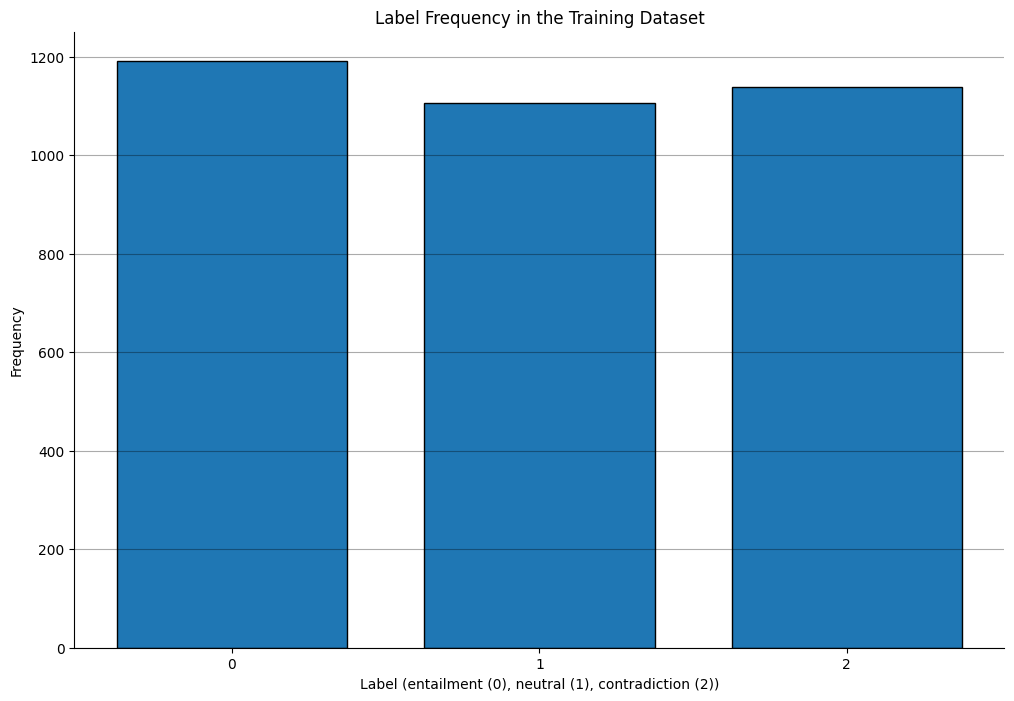

In [14]:
labels = electra_en_dataset.label.to_numpy()

plt.figure(figsize=(12, 8))

plt.hist(labels, bins=range(4), align="left", rwidth=0.75, edgecolor="black")

plt.xticks(numpy.arange(3))

for pos in ["top", "right"]:
    plt.gca().spines[pos].set_visible(False)

plt.grid(axis="y", alpha=0.33, color="black")

plt.xlabel("Label (entailment (0), neutral (1), contradiction (2))")

plt.ylabel("Frequency")

plt.title("Label Frequency in the Training Dataset")

plt.show()

- From the historgram above, it seams that the most frequent premise is an entailment, while a neutral conclusion happens the least.

In [15]:
def get_length_of_text(_text):
    return len(_text)


length_of_hypothesis_texts = electra_en_dataset.hypothesis.apply(get_length_of_text)

length_of_premise_texts = electra_en_dataset.premise.apply(get_length_of_text)

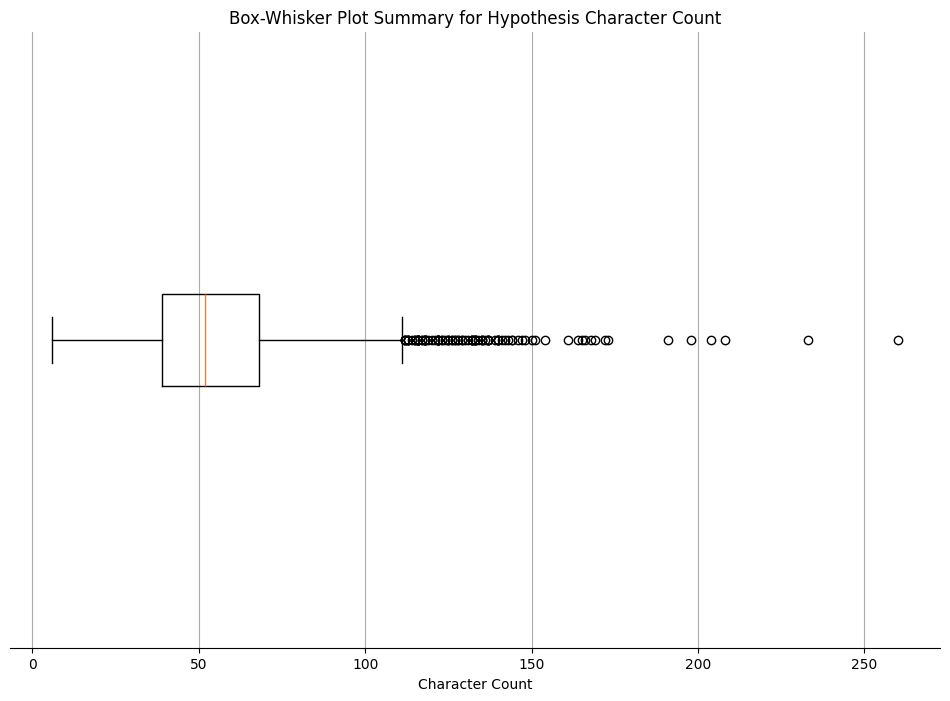

In [16]:
plt.figure(figsize=(12, 8))

plt.boxplot(length_of_hypothesis_texts, vert=False)

for pos in ["top", "right", "left"]:
    plt.gca().spines[pos].set_visible(False)

plt.gca().get_yaxis().set_visible(False)

plt.grid(axis="x", alpha=0.33, color="black")

plt.xlabel("Character Count")

plt.title("Box-Whisker Plot Summary for Hypothesis Character Count")

plt.show()

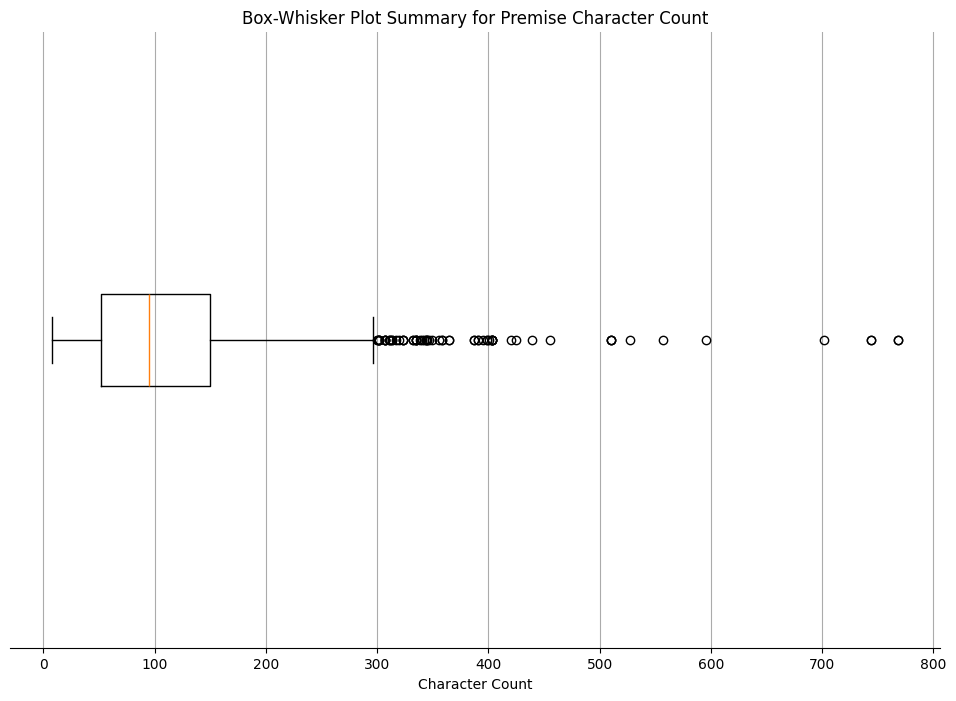

In [17]:
plt.figure(figsize=(12, 8))

plt.boxplot(length_of_premise_texts, vert=False)

for pos in ["top", "right", "left"]:
    plt.gca().spines[pos].set_visible(False)

plt.gca().get_yaxis().set_visible(False)

plt.grid(axis="x", alpha=0.33, color="black")

plt.xlabel("Character Count")

plt.title("Box-Whisker Plot Summary for Premise Character Count")

plt.show()

- From the summary plots of the character counts in the texts, it can be seen that there appear to be many outliers in the distribution. This means that there exists several text elements that are much longer than upper limits of the distribution. This may affect the encoding of the textual embeddings in the model.

- Otherwise, it would seem on average that the premises are longer than the hypotheses.

#### Model Definition

In [49]:
def split_labels(x, y):
    return (x[0], x[1]), y

def process_labels_and_predictions(datalist, logits):
    predictions = tensorflow.argmax(tensorflow.nn.softmax(logits, 1), 1).numpy()

    first_label_set_processed = False

    labels = None

    for i in range(len(datalist)):
        if not first_label_set_processed:
            labels = datalist[i][1].numpy()

            first_label_set_processed = True
        else:
            labels = numpy.hstack((labels, datalist[i][1].numpy()))

    return labels, predictions

def plot_metrics(model):
    # predict on the validation set
    validation_logits = model.predict(val_set)

    validation_set_list = list(val_set)

    labels, predictions = process_labels_and_predictions(validation_set_list, validation_logits)

    # classification report
    print(sklearn.metrics.classification_report(labels, predictions, target_names=label_names))

    # plot the confusion matrix
    matrix = sklearn.metrics.ConfusionMatrixDisplay(
        sklearn.metrics.confusion_matrix(labels, predictions),
        display_labels=label_names
    )
    matrix.plot()
    plt.show()

def get_max_token_length(dataset, preprocessor):
  token_lengths = []

  for hypothesis, premise in dataset[["hypothesis", "premise"]].values:

    encoded = preprocessor([hypothesis, premise])
    encoded_np = encoded["padding_mask" ]. numpy()
    non_padding_count = encoded_np.sum()
    token_lengths.append(non_padding_count)

  return max(token_lengths)


def plot_model_result(_losses, _accuracies, _is_training=True):
    plt.style.use('seaborn-v0_8-dark')

    fig, (momentum_loss_ax, momentum_acc_ax) = plt.subplots(1, 2, figsize=(16,6))
    momentum_loss_ax.plot(numpy.arange(1, len(_losses) + 1), _losses)
    momentum_loss_ax.set_xlabel(f"Epoch (Batch size = {batch_size})")
    momentum_loss_ax.set_xticks(numpy.arange(1, len(_losses) + 1))
    momentum_loss_ax.set_ylabel("CCE loss")
    momentum_loss_ax.set_title(f"{'Training' if _is_training else 'Validation'} Epoch vs. Loss for ELECTRA EN")
    momentum_loss_ax.grid()

    momentum_acc_ax.plot(numpy.arange(1, len(_accuracies) + 1), _accuracies)
    momentum_acc_ax.set_xlabel(f"Epoch (Batch size = {batch_size})")
    momentum_acc_ax.set_xticks(numpy.arange(1, len(_accuracies) + 1))
    momentum_acc_ax.set_ylabel("Accuracy (%)")
    momentum_acc_ax.set_yticks(numpy.arange(0, 1.1, .1))
    momentum_acc_ax.set_title(f"{'Training' if _is_training else 'Validation'} Epoch vs. Accuracy for ELECTRA EN")
    momentum_acc_ax.grid()

    plt.show()

In [19]:
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.3
TEST_SKIP = int(electra_en_dataset.shape[0] * (1-TEST_SPLIT))
VALIDATION_SKIP = int(TEST_SKIP * (1 - VALIDATION_SPLIT))

training_dataset = (
    tensorflow.data.Dataset.from_tensor_slices(
        (
            electra_en_dataset[["hypothesis", "premise"]].values,
            electra_en_dataset["label"].values
        )
    )
)

train_dataset = training_dataset.take(VALIDATION_SKIP)

val_dataset = training_dataset.skip(VALIDATION_SKIP).take(int(VALIDATION_SKIP * VALIDATION_SPLIT))

test_dataset = training_dataset.skip(TEST_SKIP)

batch_size = 32

num_epochs = 5

train_preprocessed = train_dataset.map(split_labels, tensorflow.data.AUTOTUNE).cache().shuffle(buffer_size=batch_size, seed=42).batch(batch_size, drop_remainder=True).prefetch(tensorflow.data.AUTOTUNE)
val_preprocessed = val_dataset.map(split_labels, tensorflow.data.AUTOTUNE).cache().shuffle(buffer_size=batch_size, seed=42).batch(batch_size, drop_remainder=True).prefetch(tensorflow.data.AUTOTUNE)
test_preprocessed = test_dataset.map(split_labels, tensorflow.data.AUTOTUNE).cache().shuffle(buffer_size=batch_size, seed=42).batch(batch_size, drop_remainder=True).prefetch(tensorflow.data.AUTOTUNE)

100%|██████████| 545/545 [00:00<00:00, 550kB/s]


100%|██████████| 559/559 [00:00<00:00, 611kB/s]


100%|██████████| 226k/226k [00:00<00:00, 286kB/s]


100%|██████████| 52.1M/52.1M [00:04<00:00, 11.7MB/s]


Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 235ms/step - loss: 1.0960 - sparse_categorical_accuracy: 0.3448 - val_loss: 1.0498 - val_sparse_categorical_accuracy: 0.4922
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.0277 - sparse_categorical_accuracy: 0.4776 - val_loss: 0.9563 - val_sparse_categorical_accuracy: 0.5547
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.8460 - sparse_categorical_accuracy: 0.6408 - val_loss: 0.8924 - val_sparse_categorical_accuracy: 0.6120
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.6384 - sparse_categorical_accuracy: 0.7598 - val_loss: 1.0219 - val_sparse_categorical_accuracy: 0.5964
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.4588 - sparse_categorical_accuracy: 0.8405 - val_loss: 1.0722 - val_sparse_categorical_accuracy: 0.5833


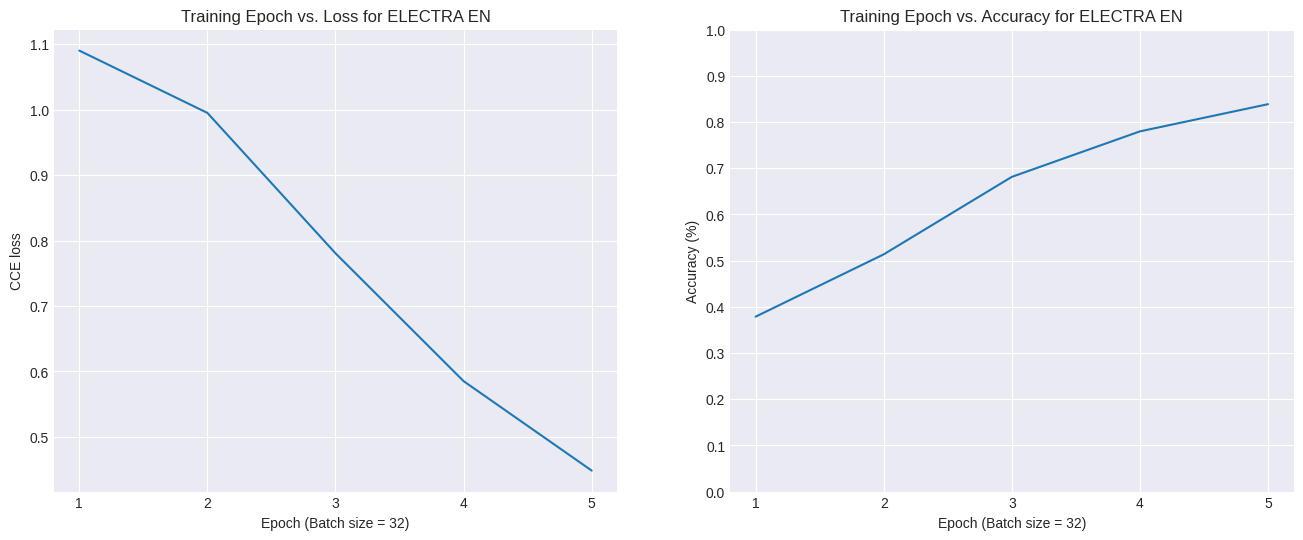

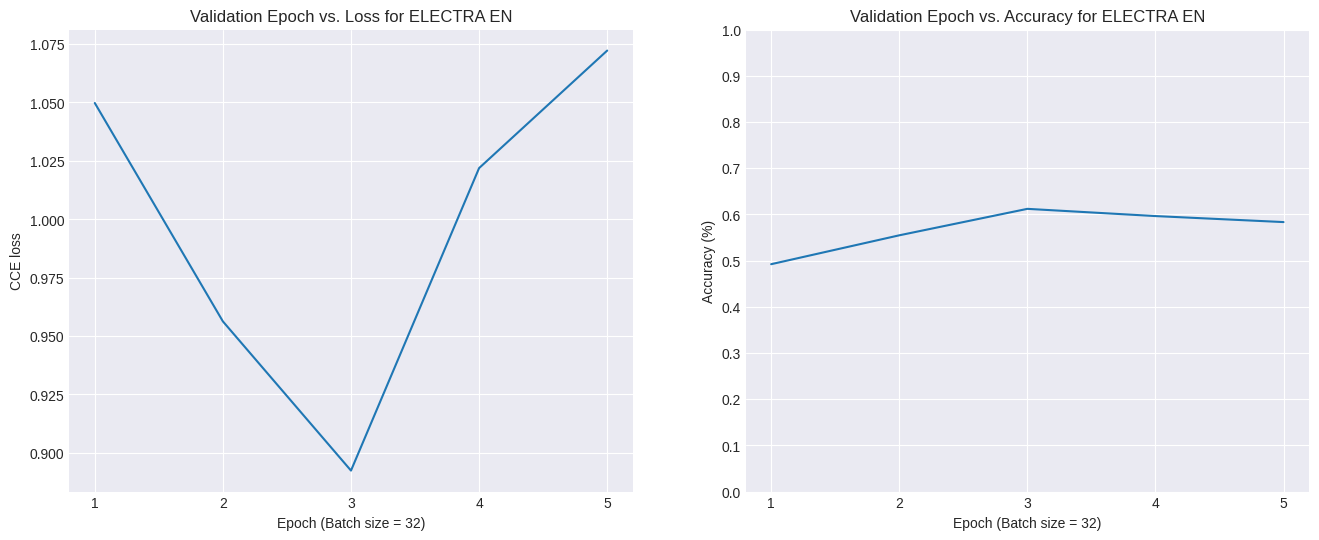

In [20]:
# electra_ganerator_token = keras_nlp.models.Tokenizer.from_preset("electra_small_generator_uncased_en")
electra_discriminator_token = keras_nlp.models.Tokenizer.from_preset("electra_small_discriminator_uncased_en")

bert_preprocessor = keras_nlp.models.BertTextClassifierPreprocessor(electra_discriminator_token, sequence_length=240)
# max_token_length = get_max_token_length(electra_en_dataset, bert_preprocessor)
# bert_preprocessor.sequence_length = max_token_length

train_set = (
    train_preprocessed.map(bert_preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE)
)

val_set = (
    val_preprocessed.map(bert_preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE)
)

# electra_generator_back = keras_nlp.models.Backbone.from_preset("electra_small_generator_uncased_en")
electra_discriminator_back = keras_nlp.models.Backbone.from_preset("electra_small_discriminator_uncased_en")

bert_classifier = keras_nlp.models.BertClassifier(electra_discriminator_back, 3, preprocessor=None)

classifier_history = bert_classifier.fit(train_set, epochs=5, validation_data=val_set)
training_losses = classifier_history.history["loss"]

training_accuracies = classifier_history.history["sparse_categorical_accuracy"]

validation_losses = classifier_history.history["val_loss"]

validation_accuracies = classifier_history.history["val_sparse_categorical_accuracy"]

plot_model_result(training_losses, training_accuracies)

plot_model_result(validation_losses, validation_accuracies, False)

#### Optimizer and Loss selection will remain set to the defaults of the preset

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
               precision    recall  f1-score   support

   entailment       0.64      0.60      0.62       123
      neutral       0.64      0.56      0.60       148
contradiction       0.48      0.59      0.53       113

     accuracy                           0.58       384
    macro avg       0.59      0.59      0.58       384
 weighted avg       0.59      0.58      0.59       384



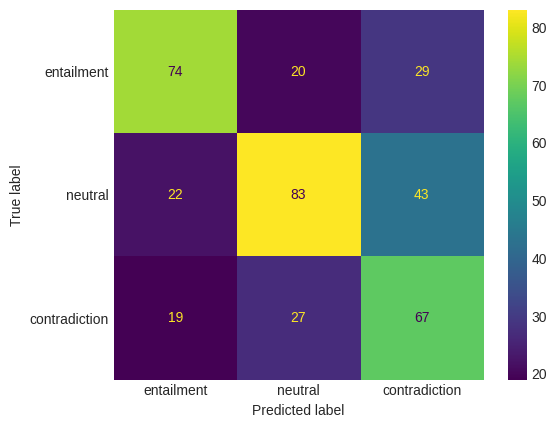

None


In [50]:
print(plot_metrics(bert_classifier))

#### Saving the Model

In [22]:
# Note that only the classifier requires the weights to be saved.
# No training is being done on the tokenizer or preprocessor since we are interested in pretraining the classifier.
dir_path = "Models/ELECTRA"
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

bert_classifier.save_weights("Models/ELECTRA/ELECTRA_EN.weights.h5")

# Hyperparameter Search

## Given we have been using keras for our model, we use keras tuner for the hyperparameter search. We wrap our model creation logic inside of a class to be able to use it in keras tuner.

In [54]:
class ElectraHyperModel(HyperModel):
    def __init__(self, backbone, num_classes, preprocessor):
        self.backbone = backbone
        self.num_classes = num_classes
        self.preprocessor = preprocessor

    def build(self, hp):
        # hyperparameters to tune
        learning_rate = hp.Float("learning_rate",
                                  min_value=1e-5,
                                  max_value=1e-3,
                                  sampling="log")

        dropout_rate = hp.Float("dropout_rate",
                                min_value=0.1,
                                max_value=0.5,
                                step=0.1)

        optimizer_choice = hp.Choice("optimizer",
                                     values=["adam", "adamw"])

        # build the model + dropout
        classifier = keras_nlp.models.BertClassifier(
            backbone=self.backbone,
            num_classes=self.num_classes,
            preprocessor=self.preprocessor,
            dropout = dropout_rate
        )

        # compile the model with the chosen hyperparameters
        if optimizer_choice == "adam":
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        else:
            optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)

        classifier.compile(
            optimizer=optimizer,
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["sparse_categorical_accuracy"]
        )

        return classifier

In [24]:
# initalize tokenizer and backbone as before
electra_discriminator_token = keras_nlp.models.Tokenizer.from_preset("electra_small_discriminator_uncased_en")
bert_preprocessor = keras_nlp.models.BertTextClassifierPreprocessor(
    electra_discriminator_token,
    sequence_length=240
)

electra_discriminator_back = keras_nlp.models.Backbone.from_preset(
    "electra_small_discriminator_uncased_en"
)

# define the hypermodel
hypermodel = ElectraHyperModel(
    backbone=electra_discriminator_back,
    num_classes=3,
    preprocessor=None  # Since you're handling preprocessing separately
)

# initialize the tuner
tuner = RandomSearch(
    hypermodel,
    objective="val_sparse_categorical_accuracy",
    max_trials=20,
    executions_per_trial=1,
    directory="kt_electra",
    project_name="electra_hyperparameter_tuning"
)

In [26]:
# define early stopping
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# run the search
tuner.search(
    train_set,
    epochs=5,  # may stop earlier
    validation_data=val_set,
    callbacks=[stop_early]
)

Trial 20 Complete [00h 01m 41s]
val_sparse_categorical_accuracy: 0.3203125

Best val_sparse_categorical_accuracy So Far: 0.6614583134651184
Total elapsed time: 00h 31m 07s


In [55]:
# get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal learning rate is {best_hps.get('learning_rate')},
the optimal dropout rate is {best_hps.get('dropout_rate')},
and the optimal optimizer is {best_hps.get('optimizer')}.
""")


The optimal learning rate is 2.090201853963144e-05,
the optimal dropout rate is 0.2,
and the optimal optimizer is adamw.



In [28]:
# build the model with the best hyperparameters
final_model = hypermodel.build(best_hps)

# train the final model
final_history = final_model.fit(
    train_set,
    epochs=5,
    validation_data=val_set,
    callbacks=[stop_early]
)

# eval the model
final_loss, final_accuracy = final_model.evaluate(val_set)
print(f"Final Validation Loss: {final_loss}")
print(f"Final Validation Accuracy: {final_accuracy}")

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 122ms/step - loss: 1.1002 - sparse_categorical_accuracy: 0.3436 - val_loss: 1.1012 - val_sparse_categorical_accuracy: 0.2943
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.0965 - sparse_categorical_accuracy: 0.3708 - val_loss: 1.0983 - val_sparse_categorical_accuracy: 0.3854
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.0990 - sparse_categorical_accuracy: 0.3368 - val_loss: 1.0983 - val_sparse_categorical_accuracy: 0.3854
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.0985 - sparse_categorical_accuracy: 0.3350 - val_loss: 1.0982 - val_sparse_categorical_accuracy: 0.3854
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.1010 - sparse_categorical_accuracy: 0.3315 - val_loss: 1.0982 - val_sparse_categorical_accuracy: 0.3854
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.0988 - sparse_categorical_accuracy: 0.3306 - val_loss: 1.0981 - val_sparse_categorical_accuracy: 0.3854
Epoch 7/

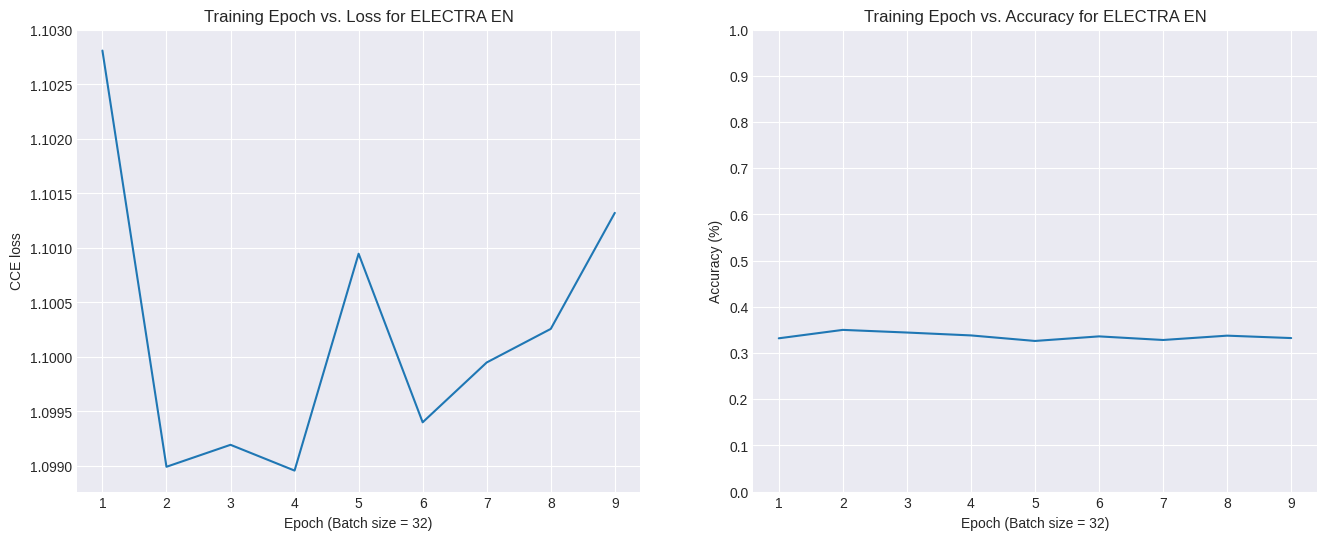

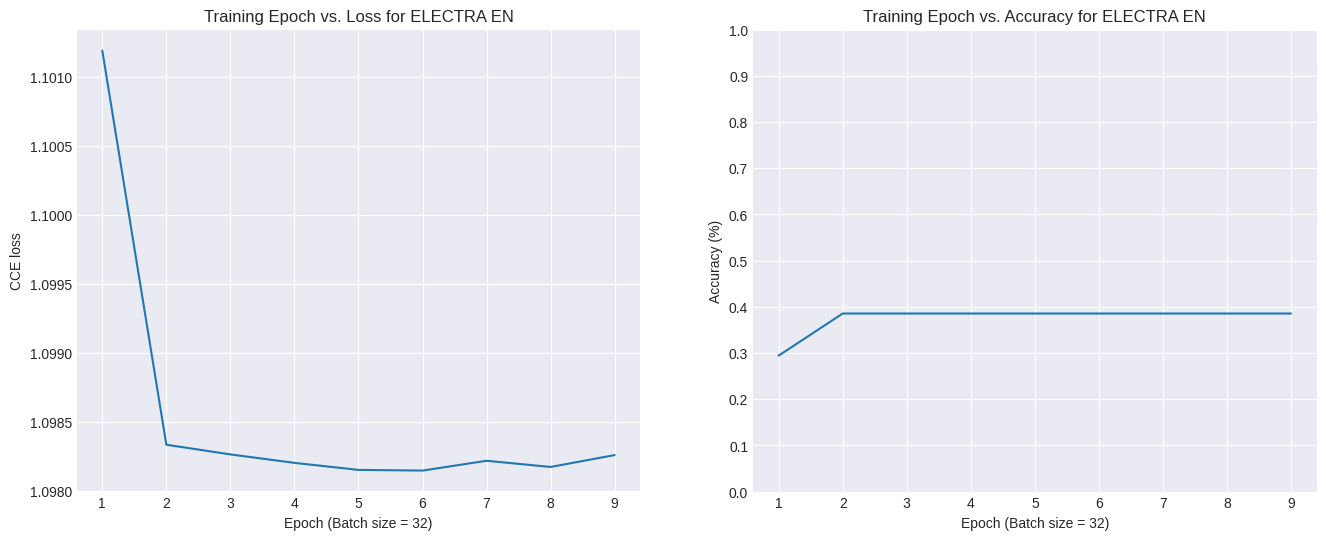

In [30]:
# plot training history
training_losses = final_history.history["loss"]
training_accuracies = final_history.history["sparse_categorical_accuracy"]
validation_losses = final_history.history["val_loss"]
validation_accuracies = final_history.history["val_sparse_categorical_accuracy"]

plot_model_result(training_losses, training_accuracies)
plot_model_result(validation_losses, validation_accuracies)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
               precision    recall  f1-score   support

   entailment       0.00      0.00      0.00       123
      neutral       0.39      1.00      0.56       148
contradiction       0.00      0.00      0.00       113

     accuracy                           0.39       384
    macro avg       0.13      0.33      0.19       384
 weighted avg       0.15      0.39      0.21       384



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


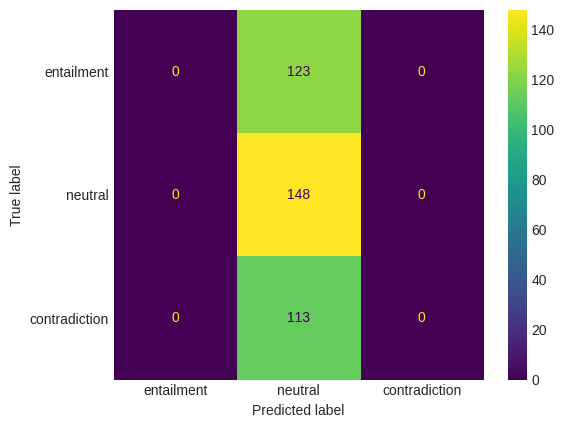

In [51]:
plot_metrics(final_model)